In [14]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.preprocessing import LabelEncoder

ruta_csv = 'combined_statistics_full.csv'
df = pd.read_csv(ruta_csv)

X = df.iloc[:, :-1]
y = df.iloc[:, -1]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
best_rf = RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=50,
                                 random_state=42)


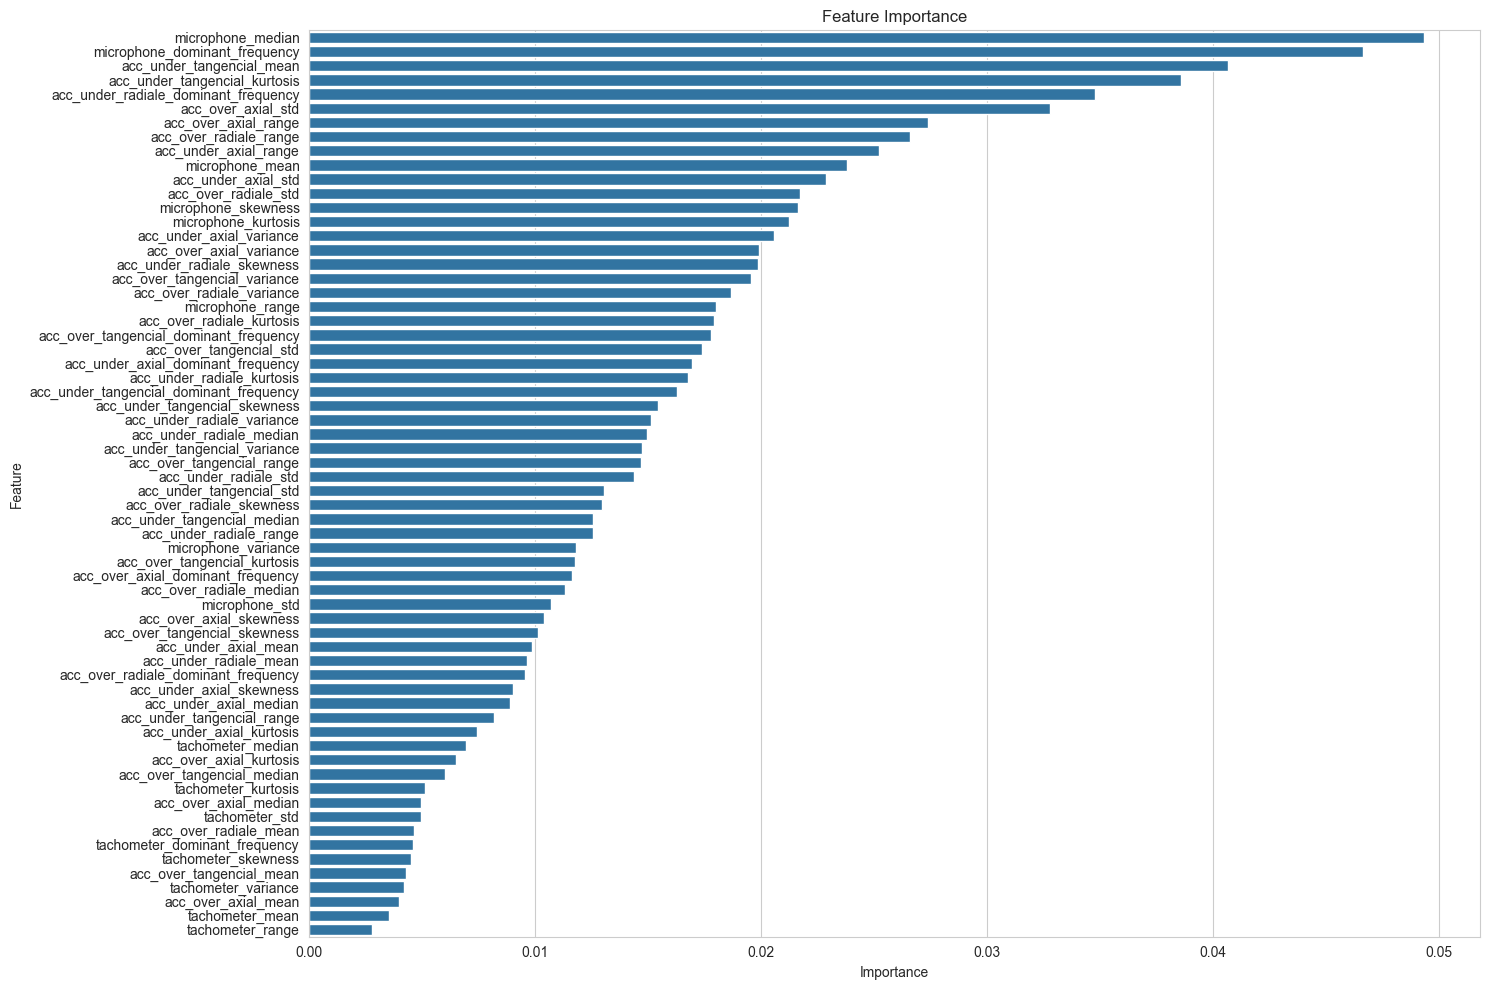

In [15]:
best_rf.fit(X_train, y_train)
def plot_feature_importance(model, feature_names, title="Feature Importance"):
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(15, 10))
    sns.barplot(data=importances, x='importance', y='feature')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    return importances

importance_df = plot_feature_importance(best_rf, X.columns)

In [16]:

total_importance = importance_df['importance'].sum()
# print(total_importance) --> efektibamente da 1

cumulative_importance = importance_df['importance'].cumsum()
selected_features = importance_df[cumulative_importance <= total_importance * 0.9]

print("\nSelected Features (90% of importance):")
print(selected_features)
X2 = X[selected_features['feature']]

X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

best_rf.fit(X_train, y_train)

rf_train_pred = best_rf.predict(X_train)
rf_test_pred = best_rf.predict(X_test)


Selected Features (90% of importance):
                                    feature  importance
57                        microphone_median    0.049350
63            microphone_dominant_frequency    0.046619
24                acc_under_tangencial_mean    0.040658
30            acc_under_tangencial_kurtosis    0.038580
23     acc_under_radiale_dominant_frequency    0.034759
34                       acc_over_axial_std    0.032769
36                     acc_over_axial_range    0.027373
44                   acc_over_radiale_range    0.026596
12                    acc_under_axial_range    0.025197
56                          microphone_mean    0.023783
10                      acc_under_axial_std    0.022850
42                     acc_over_radiale_std    0.021718
61                      microphone_skewness    0.021614
62                      microphone_kurtosis    0.021222
11                 acc_under_axial_variance    0.020552
35                  acc_over_axial_variance    0.019909
21      

In [17]:
from sklearn.inspection import permutation_importance

X = df.iloc[:, :-1]
y = df.iloc[:, -1]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


svm_basic = SVC(kernel='rbf', probability=True, random_state=42, C=100, gamma=0.01)
svm_basic.fit(X_train_scaled, y_train)

perm_importance = permutation_importance(svm_basic, X_train_scaled, y_train, n_repeats=30, random_state=42)

feature_names = df.iloc[:, :-1].columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': perm_importance.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

total_importance = importance_df['Importance'].sum()
# print(total_importance) --> efektibamente da 1

cumulative_importance = importance_df['Importance'].cumsum()
selected_features = importance_df[cumulative_importance <= total_importance * 0.9]  #cogemos el 90% de la importancia

print("\nSelected Features (90% of importance):")
print(selected_features)
X = X[selected_features['Feature']]
X_scaled = scaler.fit_transform(X)

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

svm_basic.fit(X_train_scaled, y_train)

rf_train_pred = svm_basic.predict(X_train_scaled)
rf_test_pred = svm_basic.predict(X_test_scaled)



Selected Features (90% of importance):
                                    Feature  Importance
21               acc_under_radiale_skewness    0.146218
36                     acc_over_axial_range    0.085684
37                  acc_over_axial_skewness    0.083825
30            acc_under_tangencial_kurtosis    0.078675
29            acc_under_tangencial_skewness    0.067543
50                  acc_over_tangencial_std    0.060085
46                acc_over_radiale_kurtosis    0.059722
22               acc_under_radiale_kurtosis    0.059509
13                 acc_under_axial_skewness    0.054338
31  acc_under_tangencial_dominant_frequency    0.054188
16                   acc_under_radiale_mean    0.052564
54             acc_over_tangencial_kurtosis    0.050449
18                    acc_under_radiale_std    0.049252
45                acc_over_radiale_skewness    0.048697
14                 acc_under_axial_kurtosis    0.047906
44                   acc_over_radiale_range    0.041132
8       

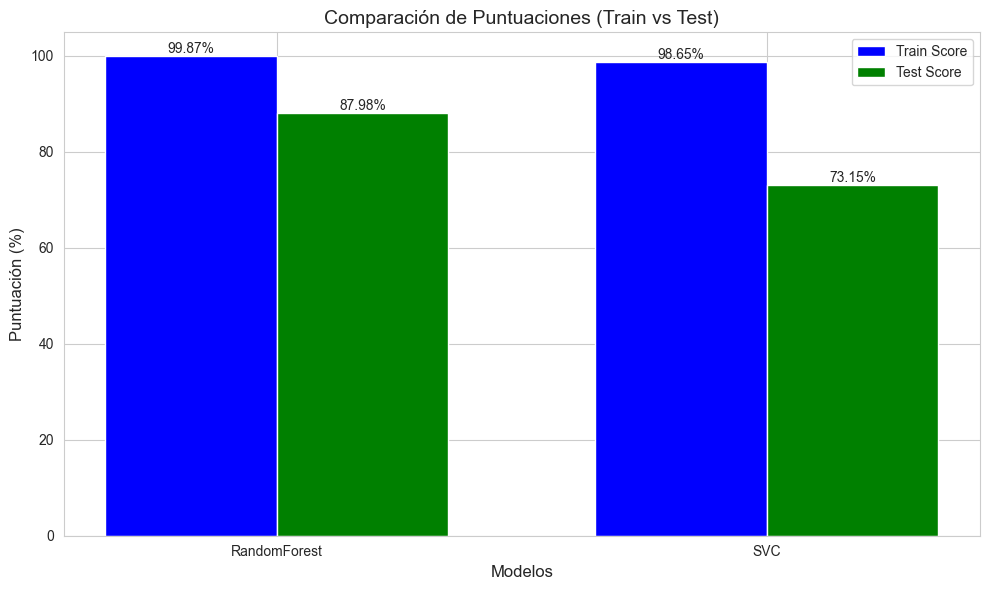

In [18]:
models = [best_rf, svm_basic]
models_names = ['RandomForest', 'SVC']

# Cálculo de puntuaciones para cada modelo
train_score = []
test_score = []

for model, name in zip(models, models_names):
    if name == 'RandomForest':
        # Usar datos sin escalar para DecisionTreeClassifier
        train_score.append(model.score(X_train, y_train))
        test_score.append(model.score(X_test, y_test))
    else:
        # Usar datos escalados para los demás modelos
        train_score.append(model.score(X_train_scaled, y_train))
        test_score.append(model.score(X_test_scaled, y_test))

# Diferencia entre las puntuaciones de entrenamiento y prueba
ratio = [f'{(train - test) * 100:.2f}%' for train, test in zip(train_score, test_score)]

# Measure model state:6
rate = []
for train, test in zip(train_score, test_score):
    if train <= 0.65 and test <= 0.65:
        rate.append('bad')
    elif train > test * 1.10 or train >= 1.00:
        rate.append('overfite')
    elif train > 0.65 and train < 0.80 and test > 0.65 and test < 0.80:
        rate.append('middle')
    elif train >= 0.80 and test >= 0.80 and train < 1.00 and test < 1.00:
        rate.append('good')
    elif train >= 0.80 and test < 0.80:
        rate.append('high train, low test')
    else:
        rate.append('unknown')

# Create DataFrame
model_score = pd.DataFrame({
    'Model': models_names,
    'Train score': [f'{round(score * 100, 2)}%' for score in train_score],
    'Test score': [f'{round(score * 100, 2)}%' for score in test_score],
    'Ratio difference': ratio,
    'Evaluate model': rate,
})

# Show result:
model_score
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
x = np.arange(len(models_names))  # Posiciones para cada modelo
train_scores = [score * 100 for score in train_score]
test_scores = [score * 100 for score in test_score]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35  # Ancho de las barras

# Barras para training y testing
train_bars = ax.bar(x - width / 2, train_scores, width, label='Train Score', color='blue')
test_bars = ax.bar(x + width / 2, test_scores, width, label='Test Score', color='green')

# Añadir etiquetas y título
ax.set_xlabel('Modelos', fontsize=12)
ax.set_ylabel('Puntuación (%)', fontsize=12)
ax.set_title('Comparación de Puntuaciones (Train vs Test)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models_names)
ax.legend()

# Mostrar valores en las barras
for bar in train_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., height, f'{height:.2f}%', ha='center', va='bottom')

for bar in test_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., height, f'{height:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

